<a href="https://colab.research.google.com/github/AsadiAhmad/Object-Detection-and-Tracking/blob/main/Code/Object_Detection_and_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import gdown

# Step 2: Download Resources

In [ ]:
gdown.download(id="1_8yBhYg747PZzKo_yjKZsG9K4_TtQ661", output="frozen_inference_graph.pb", quiet=False)
gdown.download(id="1PP9DSPG2YS8gJHkXfRA5ETPBsXOBD6mt", output="mask_rcnn_inception_v2_coco_2018_01_28.pbtxt", quiet=False)
gdown.download(id="1nlJnwrUdVSh8rYT8U4VXXhwvNCZqtBE4", output="mscoco_labels.names", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1_8yBhYg747PZzKo_yjKZsG9K4_TtQ661
To: /content/frozen_inference_graph.pb
100%|██████████| 67.1M/67.1M [00:00<00:00, 237MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PP9DSPG2YS8gJHkXfRA5ETPBsXOBD6mt
To: /content/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
100%|██████████| 183k/183k [00:00<00:00, 73.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nlJnwrUdVSh8rYT8U4VXXhwvNCZqtBE4
To: /content/mscoco_labels.names
100%|██████████| 703/703 [00:00<00:00, 1.30MB/s]


'mscoco_labels.names'

In [ ]:
!wget https://raw.githubusercontent.com/AsadiAhmad/Object-Detection-and-Tracking/main/Videos/race_car.mp4 -O race_car.mp4

--2025-05-12 18:26:49--  https://raw.githubusercontent.com/AsadiAhmad/Object-Detection-and-Tracking/main/Videos/race_car.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1795725 (1.7M) [application/octet-stream]
Saving to: ‘race_car.mp4’

race_car.mp4        100%[===================>]   1.71M  --.-KB/s    in 0.05s   

2025-05-12 18:26:50 (36.3 MB/s) - ‘race_car.mp4’ saved [1795725/1795725]



# Step 3: Load Videos

In [ ]:
first_frame = cv.VideoCapture("race_car.mp4").read()[1]

# Step 4: Define Detector Model

In [ ]:
textGraph = "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "frozen_inference_graph.pb"

net = cv.dnn.readNetFromTensorflow(modelWeights, textGraph);

# Step 5: Set Detector Parameter

In [ ]:
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

# Step 6: Load Class Names

In [ ]:
classesFile = "mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Step 7: Detect Objects

In [ ]:
blob = cv.dnn.blobFromImage(first_frame, swapRB=True, crop=False)
net.setInput(blob)
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

# Step 8: Select Largest Object to Track

In [ ]:
def get_largest_object(boxes, frame_shape, confidence_threshold=0.7):
    height, width = frame_shape[:2]
    max_area = 0
    best_box = None

    for i in range(boxes.shape[2]):
        box = boxes[0, 0, i]
        confidence = box[2]

        if confidence > confidence_threshold:
            x1, y1, x2, y2 = (box[3:7] * np.array([width, height, width, height])).astype(int)
            area = (x2 - x1) * (y2 - y1)

            if area > max_area:
                max_area = area
                best_box = [x1, y1, x2 - x1, y2 - y1]  # Convert to (x,y,w,h) format

    return best_box

In [ ]:
bbox = get_largest_object(boxes, first_frame.shape)
if bbox is None:
    print("No objects detected meeting confidence threshold")
    exit()

# Step 9: Draw First Detected frame

In [ ]:
def draw_box(frame, bbox, color=(0, 255, 0), thickness=2):
    x, y, w, h = [int(v) for v in bbox]
    cv.rectangle(frame, (x, y), (x + w, y + h), color, thickness)
    return frame

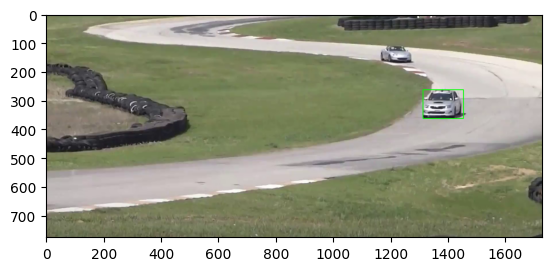

In [ ]:
first_frame_shown = draw_box(first_frame, bbox)
plt.imshow(cv.cvtColor(first_frame_shown, cv.COLOR_BGR2RGB))
plt.show()

# Step 10: Create Tracker

In [ ]:
tracker = cv.TrackerCSRT_create()
ok = tracker.init(first_frame, bbox)

In [ ]:
cap = cv.VideoCapture("race_car.mp4")

output_path = "race_car_tracked.mp4"
fps = int(cap.get(cv.CAP_PROP_FPS))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter(output_path, fourcc, fps, (width, height))

while True:
    ok, frame = cap.read()
    if not ok:
        break

    timer = cv.getTickCount()
    ok, bbox = tracker.update(frame)
    fps = cv.getTickFrequency() / (cv.getTickCount() - timer)

    if ok:
        frame = draw_box(frame, bbox, (0, 255, 0))
        cv.putText(frame, f"Tracking (FPS: {fps:.1f})", (10, 30),
                  cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    else:
        cv.putText(frame, "Tracking failure", (10, 30),
                  cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

    out.write(frame)

cap.release()
out.release()
cv.destroyAllWindows()

Tracking complete. Output saved to race_car_tracked.mp4
